In [1]:
import numpy as np
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Verify GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))
if physical_devices:
    print("Using M1 GPU:", physical_devices[0])
else:
    print("Running on CPU")

Num GPUs Available: 1
Using M1 GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Set image size
image_size = (128, 128)

# Clean corrupted images
if os.path.exists("./PetImages/cleaned"):
    shutil.rmtree("./PetImages/cleaned")

os.makedirs("./PetImages/cleaned/Cat")
os.makedirs("./PetImages/cleaned/Dog")

num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("./PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            with Image.open(fpath) as img:
                img.verify()
            shutil.copyfile(fpath, os.path.join("./PetImages/cleaned", folder_name, fname))
        except:
            num_skipped += 1

print(f"Skipped {num_skipped} images.")

Skipped 0 images.


In [4]:
# Load images and preprocess
def load_images_from_folder(folder):
    images = []
    labels = []
    for label, class_name in enumerate(["Cat", "Dog"]):
        class_path = os.path.join(folder, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path).resize(image_size)
                img = np.array(img, dtype=np.float32) / 255.0  # Normalize
                if img.shape == (128, 128, 3):  # Ensure correct shape
                    images.append(img)
                    labels.append(label)
            except Exception as e:
                print(f"Skipping {img_path} due to error: {e}")
                continue

    images = np.array(images, dtype=np.float32)  
    labels = np.array(labels, dtype=np.float32).reshape(-1, 1)  # Reshape labels for compatibility
    return images, labels

X, y = load_images_from_folder("./PetImages/cleaned")

In [5]:
# Shuffle data
indices = np.arange(len(X))
np.random.shuffle(indices)
X, y = X[indices], y[indices]

In [6]:
# Train-validation split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [7]:
# Model Architecture (Sequential)
model = keras.Sequential([
    keras.Input(shape=image_size + (3,)),
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(3, strides=2, padding="same"),
    layers.Dropout(0.25),

    layers.Conv2D(256, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(3, strides=2, padding="same"),
    layers.Dropout(0.25),

    layers.Conv2D(512, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(3, strides=2, padding="same"),
    layers.Dropout(0.25),

    layers.Conv2D(1024, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(3, strides=2, padding="same"),
    layers.Dropout(0.25),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

2025-02-24 00:38:02.867392: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-24 00:38:02.867456: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-24 00:38:02.867460: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-24 00:38:02.867626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-24 00:38:02.867810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,199,553 (23.65 MB)

 Trainable params: 6,199,553 (23.65 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile & Train Model
epochs = 25
model.compile(optimizer=keras.optimizers.Adam(3e-4),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=32)

Epoch 1/25


2025-02-24 00:39:16.830147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 166s 261ms/step - accuracy: 0.5446 - loss: 0.6825 - val_accuracy: 0.6546 - val_loss: 0.6176
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 268ms/step - accuracy: 0.6720 - loss: 0.6009 - val_accuracy: 0.7404 - val_loss: 0.5532
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 167s 267ms/step - accuracy: 0.7262 - loss: 0.5464 - val_accuracy: 0.7862 - val_loss: 0.4815
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 268ms/step - accuracy: 0.7760 - loss: 0.4880 - val_accuracy: 0.8210 - val_loss: 0.4044
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 269ms/step - accuracy: 0.8231 - loss: 0.4020 - val_accuracy: 0.8426 - val_loss: 0.3779
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 269ms/step - accuracy: 0.8495 - loss: 0.3548 - val_accuracy: 0.8484 - val_loss: 0.3485
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 169s 271ms/step - accuracy: 0.8773 - loss: 0.2973 - val_accuracy: 0.8932 - val_loss: 0.2659
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 268ms/step - accuracy: 0.8936 - loss: 0.25

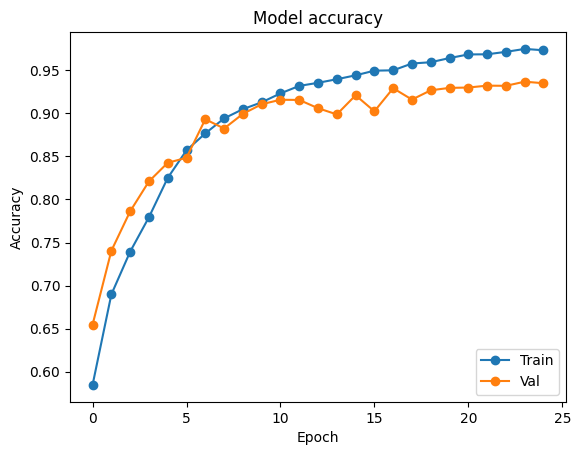

In [10]:
# Plot accuracy
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

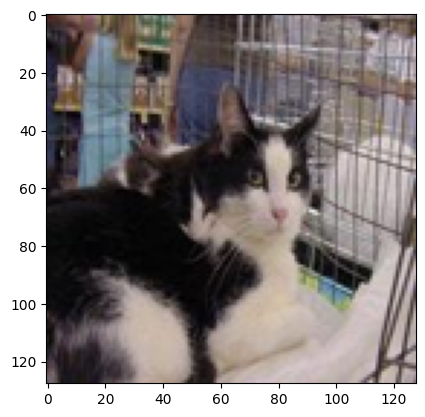

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
This image is 100.00% cat and 0.00% dog.


In [11]:
# Make a prediction
img_name = os.listdir("./PetImages/cleaned/Cat")[4]
img_path = os.path.join("./PetImages/cleaned/Cat", img_name)
img = Image.open(img_path).resize(image_size)
plt.imshow(img)
plt.show()

img_array = np.array(img, dtype=np.float32) / 255.0
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
score = predictions[0][0]
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

In [12]:
model.save("cat_vs_dogs.keras")

In [ ]:
model.load("cat_vs_dogs.keras")

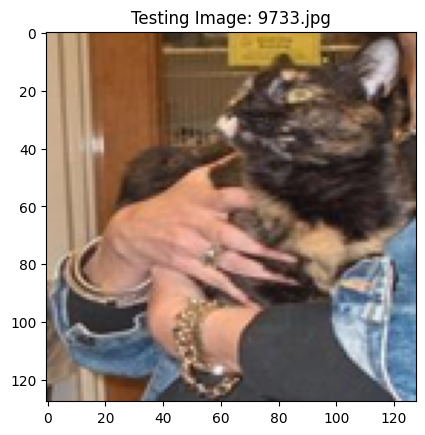

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for 9733.jpg: 99.90% Cat, 0.10% Dog


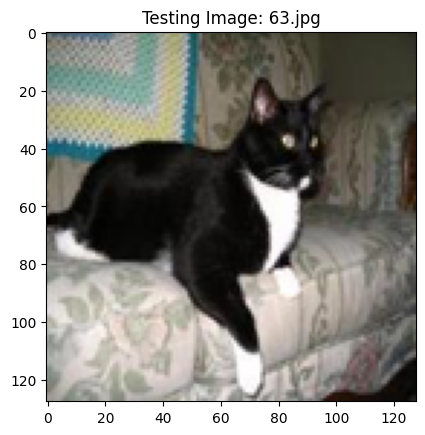

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for 63.jpg: 99.99% Cat, 0.01% Dog


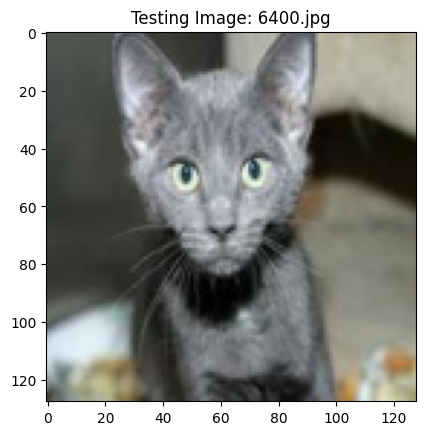

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for 6400.jpg: 100.00% Cat, 0.00% Dog


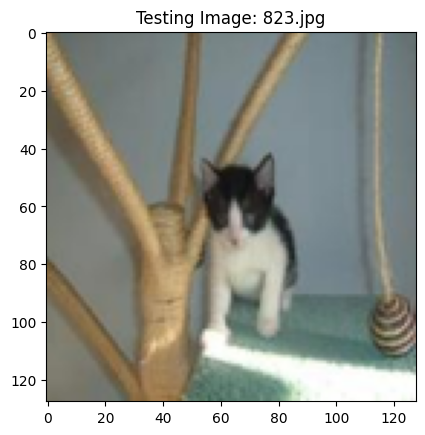

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for 823.jpg: 100.00% Cat, 0.00% Dog


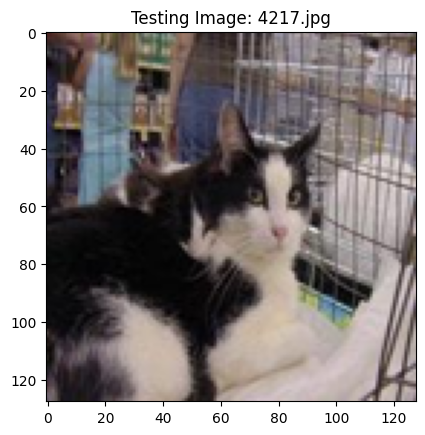

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for 4217.jpg: 100.00% Cat, 0.00% Dog


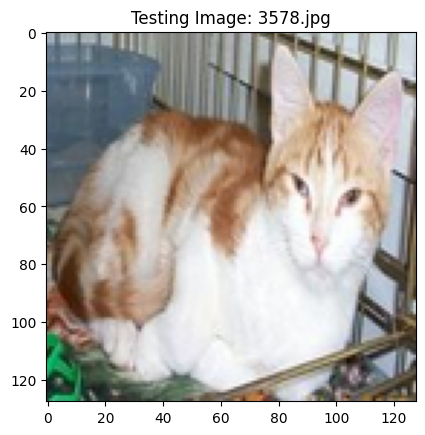

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for 3578.jpg: 100.00% Cat, 0.00% Dog


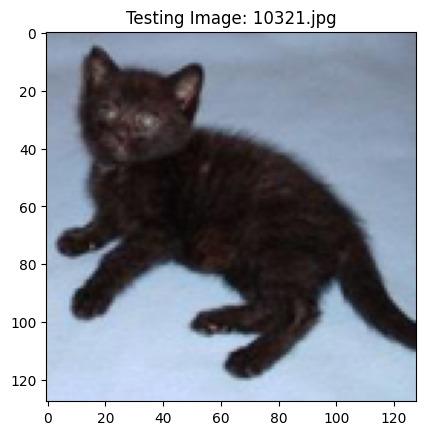

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for 10321.jpg: 100.00% Cat, 0.00% Dog


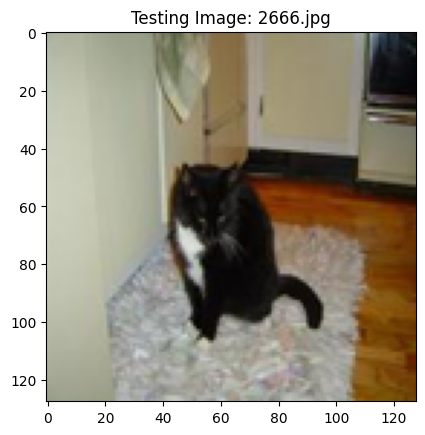

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for 2666.jpg: 99.27% Cat, 0.73% Dog


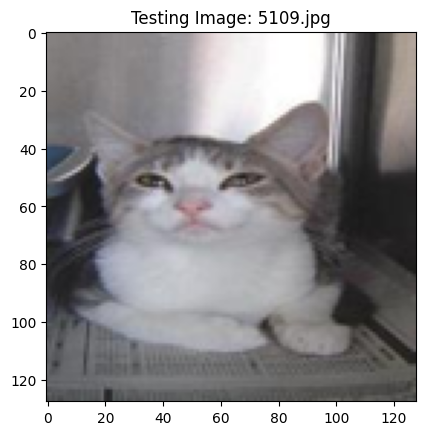

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for 5109.jpg: 99.99% Cat, 0.01% Dog


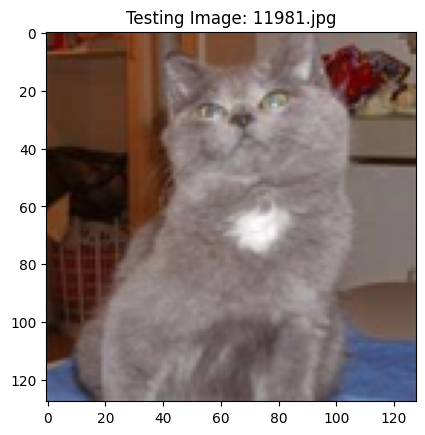

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for 11981.jpg: 99.99% Cat, 0.01% Dog


In [14]:
# Testing multiple images
num_test_images = 10  # Number of test images to predict
test_folder = "./PetImages/cleaned/Cat"  # Change to "./PetImages/cleaned/Dog" to test dog images

test_images = os.listdir(test_folder)[:num_test_images]  # Get first N images

for img_name in test_images:
    img_path = os.path.join(test_folder, img_name)
    img = Image.open(img_path).resize(image_size)
    
    # Show the image
    plt.imshow(img)
    plt.title(f"Testing Image: {img_name}")
    plt.show()

    # Preprocess and predict
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    score = predictions[0][0]
    
    print(f"Prediction for {img_name}: {100 * (1 - score):.2f}% Cat, {100 * score:.2f}% Dog")

Enter the path of the image to test:  ./abo.jpg


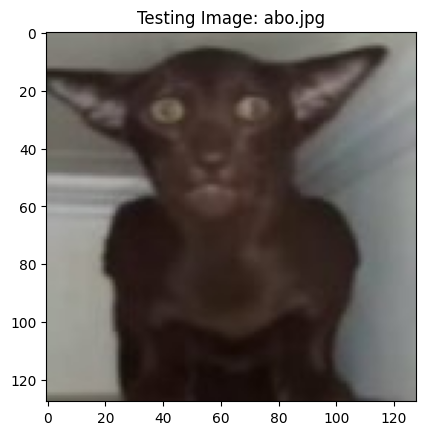

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction for abo.jpg: 80.22% Cat, 19.78% Dog


In [ ]:
# Function to predict custom image
image_path = "./abo.jpg"
def predict_image(image_path):
    try:
        img = Image.open(image_path).resize(image_size)
        
        # Show the image
        plt.imshow(img)
        plt.title(f"Testing Image: {os.path.basename(image_path)}")
        plt.show()

        # Preprocess and predict
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        predictions = model.predict(img_array)
        score = predictions[0][0]
        
        print(f"Prediction for {os.path.basename(image_path)}: {100 * (1 - score):.2f}% Cat, {100 * score:.2f}% Dog")

    except Exception as e:
        print(f"Error loading image: {e}")

# Get user input for testing image path
# image_path = input("Enter the path of the image to test: ")
predict_image(image_path)